In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten,Conv2DTranspose,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [4]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
im_size=x_train.shape[1]
x_train = np.reshape(x_train,[-1,im_size,im_size,1])
x_test = np.reshape(x_test,[-1,im_size,im_size,1])
x_train = x_train/255
x_test = x_test/255


In [8]:
ip_shape = (im_size,im_size,1)
layers=[32,64]
inputs = Input(shape=ip_shape,name='encoder_ip')
x=inputs
for layer in layers:
    x = Conv2D(layer,kernel_size=3,strides=2,padding='same',activation='relu')(x) #2 stride with same padding makes img dims half
shape = K.int_shape(x) # would be (b_size,7,7,64) for MNIST
#now flatten it
x = Flatten()(x)
#now add dense layer to make it latent dimensional encoded.
latent = Dense(20,name='latent_vec')(x) #don't add relu here.(we need the latent vector itself)

encoder = Model(inputs,latent,name='encoder')




    

In [9]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_ip (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vec (Dense)           (None, 20)                62740     
Total params: 81,556
Trainable params: 81,556
Non-trainable params: 0
_________________________________________________________________


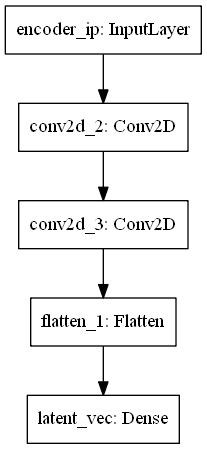

In [11]:
plot_model(encoder)

In [20]:
#Decoder Network
latent_ip = Input(shape=(20,),name='decoder_ip')
y = latent_ip
y = Dense(shape[1]*shape[2]*shape[3])(y)
y = Reshape((shape[1],shape[2],shape[3]))(y)
for layer in layers[::-1]:
    y = Conv2DTranspose(filters=layer,kernel_size=3,activation='relu',strides=2,padding='same')(y) #this would double img width,h, half the depth
#now shape would be 28*28*32
op = Conv2DTranspose(filters=1,padding='same',kernel_size=3,activation='sigmoid')(y)#this gives 28*28*1


In [21]:
decoder = Model(latent_ip,op,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_ip (InputLayer)      [(None, 20)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              65856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 121,537
Trainable params: 121,537
Non-trainable params: 0
_____________________________________________________

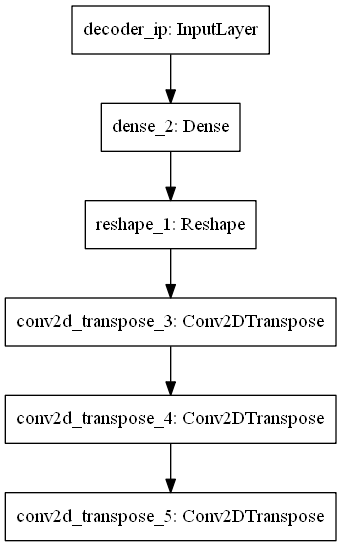

In [22]:
plot_model(decoder)

In [24]:
#making the autoencoder
autoencoder = Model(inputs,decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_ip (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 20)                81556     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         121537    
Total params: 203,093
Trainable params: 203,093
Non-trainable params: 0
_________________________________________________________________


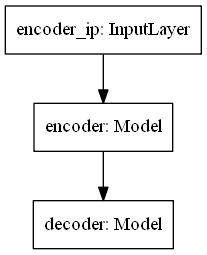

In [25]:
plot_model(autoencoder)

In [26]:
autoencoder.compile(optimizer='adam',loss='mse')

In [27]:
autoencoder.fit(x_train,x_train,validation_data=(x_test,x_test),epochs=2,batch_size=32) #validate with x_test,x_test(as we want same ip)


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 29s 481us/sample - loss: 0.0187 - val_loss: 0.0084
Epoch 2/2
60000/60000 [==============================] - 15s 244us/sample - loss: 0.0078 - val_loss: 0.0072


In [28]:
x_decoded = autoencoder.predict(x_test)

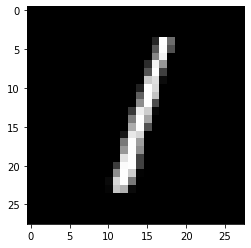

In [94]:
plt.imshow(np.reshape(x_test[2],(im_size,im_size)),cmap='gray')

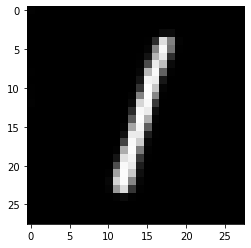

In [86]:
plt.imshow(np.reshape(x_decoded[2],(im_size,im_size)),cmap='gray')

In [64]:
#hence images have been decoded from a  20 dim latent vector shown below
#images corresp to 2,202 are representing digit 1. they have similar 1D representations.

In [87]:
new = encoder.predict(np.reshape(x_test[2],(1,im_size,im_size,1)))

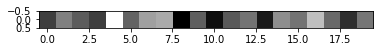

In [88]:
plt.imshow(np.reshape(new,(1,20)),cmap='gray')

In [90]:
new = encoder.predict(np.reshape(x_test[202],(1,im_size,im_size,1)))

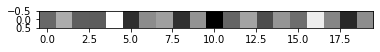

In [91]:
plt.imshow(np.reshape(new,(1,20)),cmap='gray')

In [92]:
new = encoder.predict(np.reshape(x_test[200],(1,im_size,im_size,1)))

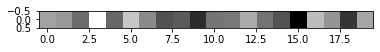

In [93]:
plt.imshow(np.reshape(new,(1,20)),cmap='gray')